In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
# Print whether CPU or GPU is used.
device = torch.device("cuda:0")


## **Populate the Data for m, k1, k2, x, and y**

In [18]:
m = np.random.uniform(0,1,(1,100000)) 
k1 = np.random.uniform(0,1,(1,100000))
k2 = k1
g=9.81
term = m * g / (k1 + k2)
posy =  np.sqrt( term ** 2 + term)# fill in the blank
posx =  0.5 * np.ones((1, 100000))# fill in the blank

In [19]:
m_test = np.random.uniform(0,1,(1,100000))
k1_test = np.random.uniform(0,1,(1,100000))
k2_test = k1_test
g = 9.81
term = m * g / (k1_test + k2_test)
posy_test = np.sqrt( term ** 2 + term)  # fill in the blank
posx_test = 0.5 * np.ones((1, 100000)) # fill in the blank

In [20]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [21]:
batch_size = 1000 #Choose your own batch size

In [22]:
data_input = np.column_stack(np.concatenate([k1, k2, posx, posy]))  # Fill in the input data format size : ()
data_output = np.transpose(m) 
data_input_test = np.column_stack(np.concatenate([k1_test, k2_test, posx_test, posy_test]))   # Fill in the input data format size : ()
data_output_test =np.transpose(m_test) 

In [23]:
train_data = Data(data_input, data_output)
train_set = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(data_input_test, data_output_test)
test_set = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [24]:
from torch.autograd import Variable
input_size = 4 # fill in the blank. 
hidden_layer_size = 10 # fill in the blank. 
learning_rate = 0.05 # fill in the blank. 
num_epochs = 100 # fill in the blank. 
class RegressionModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.dense_h1 = nn.Linear(in_features=input_size, out_features=hidden_size) 
        self.relu_h1 = nn.ReLU()# choose your own activation function
        self.dense_h2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)  
        self.relu_h2 = nn.ReLU() # choose your own activation function
        self.dropout = nn.Dropout(p=0.5)
        self.dense_out = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, X):

        out = self.relu_h1(self.dense_h1(X))
        out = self.relu_h2(self.dense_h2(out))
        out = self.dropout(out)
        out = self.dense_out(out)

        return out

m = RegressionModel(input_size=input_size, hidden_size=hidden_layer_size)

cost_func = nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate) 

all_losses = []
for e in range(num_epochs):
    batch_losses = []

    for ix, (Xb, yb) in enumerate(train_set):

        _X = Variable(Xb).float()
        _y = Variable(yb).float()

        #==========Forward pass===============

        preds = m(_X)
        loss = cost_func(preds, _y)

        #==========backward pass==============

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.data)
        all_losses.append(loss.data)

    mbl = np.mean(np.sqrt(batch_losses)).round(3)

    if e % 5 == 0:
        print("Epoch [{}/{}], Batch loss: {}".format(e, num_epochs, mbl))

# prepares model for inference when trained with a dropout layer
print(m.training)
m.eval()
print(m.training)

test_batch_losses = []
for _X, _y in test_set:

    _X = Variable(_X).float()
    _y = Variable(_y).float()

    #apply model
    test_preds = m(_X)
    test_loss = cost_func(test_preds, _y)

    test_batch_losses.append(test_loss.data)
    print("Batch loss: {}".format(test_loss.data))

Epoch [0/100], Batch loss: 6.22599983215332
Epoch [5/100], Batch loss: 0.24799999594688416
Epoch [10/100], Batch loss: 0.2460000067949295
Epoch [15/100], Batch loss: 0.24400000274181366
Epoch [20/100], Batch loss: 0.24400000274181366
Epoch [25/100], Batch loss: 0.24400000274181366
Epoch [30/100], Batch loss: 0.24400000274181366
Epoch [35/100], Batch loss: 0.24400000274181366
Epoch [40/100], Batch loss: 0.24300000071525574
Epoch [45/100], Batch loss: 0.24199999868869781
Epoch [50/100], Batch loss: 0.24300000071525574
Epoch [55/100], Batch loss: 0.24300000071525574
Epoch [60/100], Batch loss: 0.24300000071525574
Epoch [65/100], Batch loss: 0.24199999868869781
Epoch [70/100], Batch loss: 0.24300000071525574
Epoch [75/100], Batch loss: 0.24300000071525574
Epoch [80/100], Batch loss: 0.24300000071525574
Epoch [85/100], Batch loss: 0.24300000071525574
Epoch [90/100], Batch loss: 0.24199999868869781
Epoch [95/100], Batch loss: 0.24300000071525574
True
False
Batch loss: 0.09337511658668518
Bat

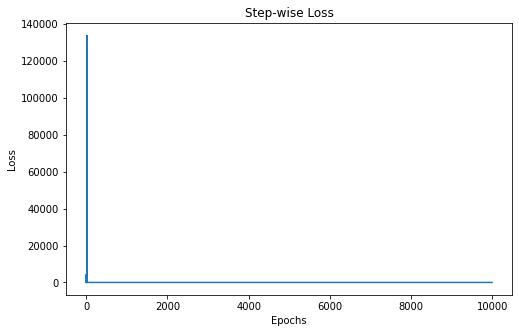

In [25]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.array(all_losses))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [26]:
# test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# result = model(X)
# print(y)

In [27]:
print(np.mean(test_batch_losses))

0.09211322
